# SKN 19기 mini-project 5팀(팀명: 여권어디있지) M/L

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# pandas 출력 옵션
pd.set_option('display.float_format', '{:.2f}'.format)

# 한글 폰트 사용을 위한 설정
import matplotlib.font_manager as fm
import matplotlib

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)

어매니티
amnt_self_checkin                0
amnt_instant_book                0
amnt_kitchen                     0
amnt_hair_dryer                  0
amnt_free_parking                0
amnt_wifi                        0
amnt_private_bathroom            0
amnt_bbq_grill                   0
amnt_washer                      0
amnt_pets_allowed                0
amnt_clothes_dryer               0
amnt_heating                     0
amnt_air_conditioning            0
amnt_workspace                   0
amnt_iron                        0
amnt_pool                        0
amnt_bathtub                     0
amnt_ev_charger                  0
amnt_crib                        0
amnt_king_bed                    0
amnt_gym                         0
amnt_breakfast                   0
amnt_fireplace                   0
amnt_smoking_allowed             0
amnt_waterfront                  0
amnt_smoke_alarm                 0
amnt_carbon_monoxide_alarm       0

살릴 것: 'amnt_self_checkin', 'amnt_hair_dryer', 'amnt_wifi', 'amnt_air_conditioning'

## 데이터 로드

In [92]:
# 데이터 로드
# 6. 데이터 변환 및 피처 엔지니어링
# 7. 데이터 분할

In [176]:
df = pd.read_csv('listings_cleaned_1st.csv')

df_listings = df.drop(df.iloc[:, 11:], axis=1)
live_list = ['amnt_self_checkin', 'amnt_hair_dryer', 'amnt_wifi', 'amnt_air_conditioning', 'amnt_pool']

# 살릴 어매니티 네 칼럼 저장
df_listings[live_list] = df[live_list]

In [175]:
df_listings.head()

,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,first_review,...,amnt_ev_charger,amnt_crib,amnt_king_bed,amnt_gym,amnt_breakfast,amnt_fireplace,amnt_smoking_allowed,amnt_waterfront,amnt_smoke_alarm,amnt_carbon_monoxide_alarm
0,Bunkyo Ku,Entire rental unit,Entire home/apt,3,1.00,0.00,2.00,100000.00,0,NaN,...,0,0,0,0,0,1,0,0,1,0
1,Bunkyo Ku,Entire rental unit,Entire home/apt,8,1.00,2.00,5.00,100000.00,0,NaN,...,0,0,0,0,0,1,0,0,1,0
2,Taito Ku,Entire serviced apartment,Entire home/apt,4,2.00,2.00,2.00,14550.00,24,2023-12-04,...,0,0,0,0,0,0,0,0,1,1
3,Kita Ku,Entire home,Entire home/apt,8,1.00,3.00,6.00,22012.00,15,2024-01-10,...,0,0,0,0,0,0,0,0,1,1
4,Sumida Ku,Entire rental unit,Entire home/apt,3,1.00,1.00,1.00,15429.00,17,2023-12-26,...,0,1,0,0,0,1,0,0,1,1


In [ ]:
# neighbourhood cleansed 라벨인코딩 - 트리는 영향 x
from sklearn.preprocessing import LabelEncoder
l_encod = LabelEncoder()

df_listings['neighbourhood_cleansed'] = l_encod.fit_transform(df_listings['neighbourhood_cleansed'])
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23007 entries, 0 to 23006
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   neighbourhood_cleansed  23007 non-null  int64  
 1   property_type           23007 non-null  object 
 2   room_type               23007 non-null  object 
 3   accommodates            23007 non-null  int64  
 4   bathrooms               23007 non-null  float64
 5   bedrooms                23007 non-null  float64
 6   beds                    23007 non-null  float64
 7   price                   23007 non-null  float64
 8   number_of_reviews       23007 non-null  int64  
 9   first_review            19875 non-null  object 
 10  review_scores_rating    19875 non-null  float64
 11  amnt_self_checkin       23007 non-null  int64  
 12  amnt_hair_dryer         23007 non-null  int64  
 13  amnt_wifi               23007 non-null  int64  
 14  amnt_air_conditioning   23007 non-null

first review, review scores rating 칼럼의 결측치
- first review의 결측치 행과 review scores rating의 결측치 행이 완벽히 일치함
- first review의 NaN은 '아직 없다' -> '리뷰가 없다' -> review scores rating = 0 으로 해석 가능하지만, review scores rating만 보면 NaN을 0점으로 두는 건 의미상 애매.
- 아니면 결측치를 따로 분류해주는 Boosting 모델 사용 필요

In [178]:
# 1.2) first_rivew 컬럼의 데이터 타입 변환
df_listings['first_review'] = pd.to_datetime(df_listings['first_review'], errors='coerce')

print(df_listings['first_review'].dtype)
print('-' * 50)
df_listings[['first_review']].head(15)

datetime64[ns]
--------------------------------------------------


,first_review
0,NaT
1,NaT
2,2023-12-04
3,2024-01-10
4,2023-12-26
5,2023-12-26
6,2023-12-10
7,2023-12-24
8,2023-12-10
9,2023-12-07


In [179]:
# 2) 피처 엔지니어링
# - 숙소의 open 시기가 다르므로 number_of_riews와 first_review를 이용해 새로운 특성 생성

# 기준 날짜 설정
reference_date = pd.to_datetime('2025-06-27')
# first_review가 결측치인 경우 NaT로 처리되어도 안전하게 계산
df_listings['days_since_first_review'] = (reference_date - df_listings['first_review']).dt.days
# 결측치가 있으면 결과도 NaN
df_listings['reviews_per_day_since_first_review'] = df_listings['number_of_reviews'] / df_listings['days_since_first_review']
# 결과 확인
df_listings[['number_of_reviews', 'first_review', 'days_since_first_review', 
             'reviews_per_day_since_first_review']].head(10)

,number_of_reviews,first_review,days_since_first_review,reviews_per_day_since_first_review
0,0,NaT,NaN,NaN
1,0,NaT,NaN,NaN
2,24,2023-12-04,571.00,0.04
3,15,2024-01-10,534.00,0.03
4,17,2023-12-26,549.00,0.03
5,14,2023-12-26,549.00,0.03
6,47,2023-12-10,565.00,0.08
7,56,2023-12-24,551.00,0.10
8,70,2023-12-10,565.00,0.12
9,55,2023-12-07,568.00,0.10


In [180]:
# room_type 라벨 인코딩
l_encod = LabelEncoder()

df_listings['room_type'] = l_encod.fit_transform(df_listings['room_type'])
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23007 entries, 0 to 23006
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   neighbourhood_cleansed              23007 non-null  int64         
 1   property_type                       23007 non-null  object        
 2   room_type                           23007 non-null  int64         
 3   accommodates                        23007 non-null  int64         
 4   bathrooms                           23007 non-null  float64       
 5   bedrooms                            23007 non-null  float64       
 6   beds                                23007 non-null  float64       
 7   price                               23007 non-null  float64       
 8   number_of_reviews                   23007 non-null  int64         
 9   first_review                        19875 non-null  datetime64[ns]
 10  review_scores_rating  

In [ ]:
# infinite값을 NaN으로 대체
df_listings.replace([np.inf, -np.inf], np.nan, inplace=True)

df_test = df_listings.drop(['property_type', 'number_of_reviews', 'first_review', 'days_since_first_review'], axis=1)

In [ ]:
# 학습-검사 데이터 분리
from sklearn.model_selection import train_test_split

X = df_test.drop('price', axis=1)
y = df_test['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# 버릴 것

In [106]:
# 1. SVR 모델 학습
    # - train, test 데이터 나누기
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

X = df_test.drop('price', axis=1)
y = df_test['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [107]:
# 1. SVR 모델 학습
    # - kernel='rbf' 고정, C값 변화에 따른 평가
C = [100, 500, 1000, 2000, 5000, 10000]
for c in C:
    svr = SVR(kernel='rbf', C=c)
    svr.fit(X_train, y_train)
    print(f'c={c}일 때 {svr.score(X_train, y_train)}, {svr.score(X_test, y_test)}')

ValueError: Input X contains NaN.
SVR does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# 1. SVR 모델 학습
    # - 교차 검증. 0.33~0.38
from sklearn.model_selection import cross_validate

model = SVR(C=10000)
scores = cross_validate(model, X, y, cv=3)
print("교차검증 결과")
scores

교차검증 결과


{'fit_time': array([9.0364964 , 9.51146293, 9.14123583]),
 'score_time': array([8.25092769, 8.2622757 , 8.1827054 ]),
 'test_score': array([0.17288002, 0.36030653, 0.29355316])}

In [ ]:
# 2. 결정트리 모델 학습
    # - max_depth 값만 바꾸어 가며 테스트. 8일 때 굿
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=9)
#   random_state= 고정하는 이유: 질문의 형태가 달라져서(가하는 규칙이 달라져서) test 데이터 평가 점수도 달라짐
dt_reg.fit(X_train, y_train)

print(dt_reg.score(X_train, y_train), dt_reg.score(X_test, y_test))

# max_depth = 6일 때 0.45241919224702387 0.46516175222154543
# max_depth = 7일 때 0.4897668291727424 0.4781175264605855
# max_depth = 8일 때 0.5369293617954587 0.4868926609519989
# max_depth = 9일 때 0.5909235200446562 0.4881666649163173

0.5909235200446562 0.4881666649163173


In [ ]:
# 1. SVR 모델 학습
    # - 교차 검증 0.39 ~ 0.46
from sklearn.model_selection import cross_validate

model = DecisionTreeRegressor(max_depth = 7)
scores = cross_validate(model, X, y, cv=5)
print("교차검증 결과")
scores

교차검증 결과


{'fit_time': array([0.06186557, 0.0432055 , 0.052495  , 0.04203296, 0.04188418]),
 'score_time': array([0.        , 0.00527048, 0.        , 0.00382185, 0.00425768]),
 'test_score': array([0.3948815 , 0.39997587, 0.41349144, 0.46241887, 0.32891093])}

In [ ]:
# 4. GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor

gb_reg = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4
)

gb_reg.fit(X_train, y_train)

gb_reg.score(X_train, y_train), gb_reg.score(X_test, y_test)
# max_depth = 5, 0.1 (0.6794981648077398, 0.5775305811768991) < 과적합...
# max_depth = 5, 0.05 (0.6263313403666386, 0.5810145654056729)
# max_depth = 5, 0.01 (0.48996312827868393, 0.5112532107502371) < ??

# max_depth = 4, 0.05 (0.577395618662224, 0.5754668665484852)

ValueError: Input X contains NaN.
GradientBoostingRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# 살릴 것

In [ ]:
# 3. 랜덤포레스트 모델 평가
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=1000, max_depth=8, random_state=0)

rf_reg.fit(X_train, y_train)
rf_reg.score(X_train, y_train), rf_reg.score(X_test, y_test)

# n_estimators=1000, max_depth=8: (0.5896532074532111, 0.5376219924051828)

(0.5896532074532111, 0.5376219924051828)

In [191]:
# 5. histGradientBoosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

hist_gb_reg = HistGradientBoostingRegressor(
    learning_rate=0.08,
    max_depth=8,
    max_bins=255,
    
    early_stopping=True,
    n_iter_no_change=5,
    l2_regularization=.5,
    min_samples_leaf=10
)

hist_gb_reg.fit(X_train, y_train)

hist_gb_reg.score(X_train, y_train), hist_gb_reg.score(X_test, y_test)

# learning_rate = 0.08, max_depth=7, max_bins=255: (0.6116290914260091, 0.5756838359665055)
# learning_rate = 0.08, max_depth=8, max_bins=255: (0.6276834902329566, 0.5805799142557486)
# learning_rate = 0.08, max_depth=8, max_bins=100: (0.614096168205037, 0.5824295280414169)

(0.6189404885503038, 0.5786162517321831)

0.562699962708922 0.5697620689456854


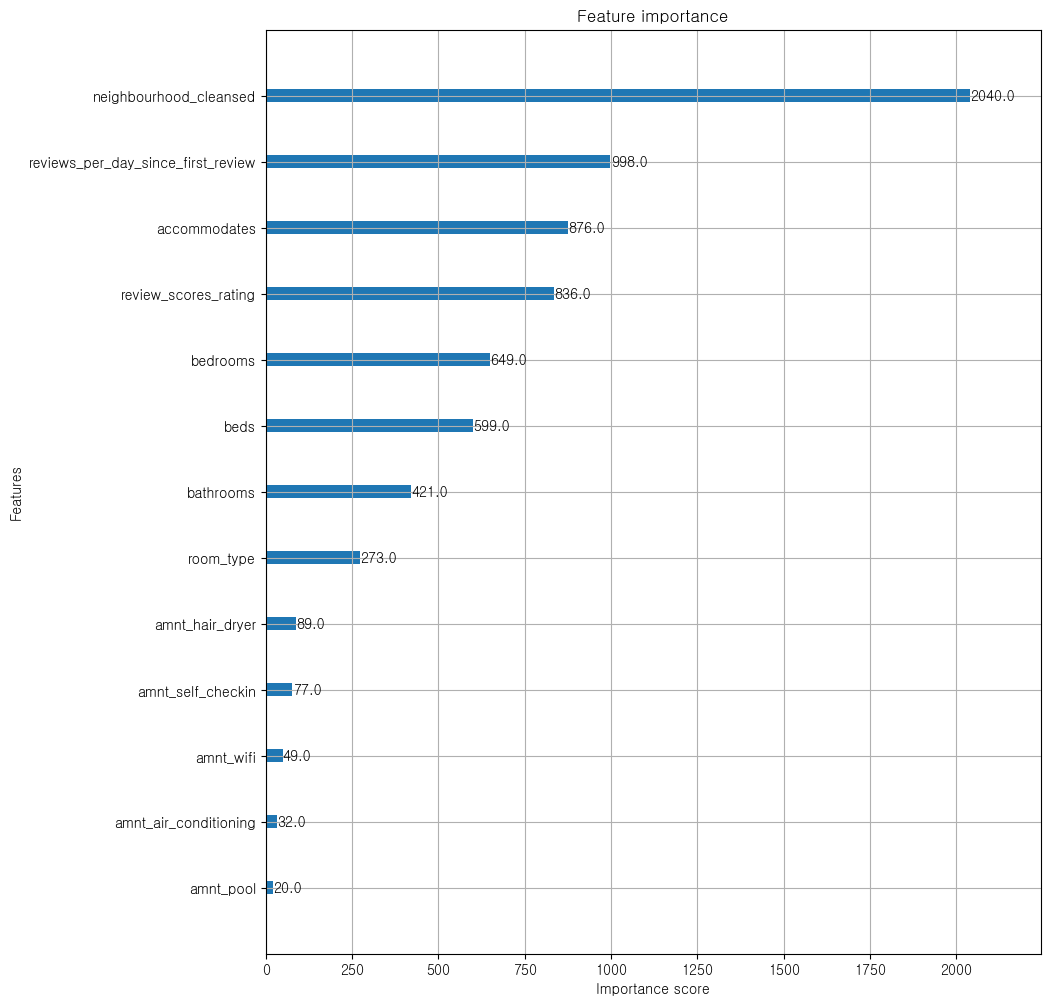

In [196]:
# XGBoost
from xgboost import XGBRegressor

xg_reg = XGBRegressor(
    n_estimators = 1000,
    max_depth=3,
    learning_rate = 0.02,
    # random_state = 0
)

xg_reg.fit(X_train, y_train)

print(xg_reg.score(X_train, y_train), xg_reg.score(X_test, y_test))

# max_depth = 3, learning_rate = 0.05일 때: 0.6005278380730942 0.5731623793639327
# max_depth = 3, learning_rate = 0.02일 때: 0.5625039501410967 0.5699039245930739

from xgboost import plot_importance
# feature 중요도를 따로 빼서 계산할 필요 x

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xg_reg, ax=ax)
plt.show()


# LightGBM 집중 학습 (피쳐 엔지니어링)

In [30]:
# 데이터 로드
df_listings = pd.read_csv('listings_cleaned_1st.csv')

# df_listings = df.drop(df.iloc[:, 11:], axis=1)
# live_list = ['amnt_self_checkin', 'amnt_hair_dryer', 'amnt_wifi', 'amnt_air_conditioning', 'amnt_free_parking' , 'amnt_pool']

# 살릴 어매니티 네 칼럼 저장
# df_listings[live_list] = df[live_list]


# neighbourhood cleansed, room_type 라벨인코딩
from sklearn.preprocessing import LabelEncoder
l_encod = LabelEncoder()
df_listings['room_type'] = l_encod.fit_transform(df_listings['room_type'])
df_listings['neighbourhood_cleansed'] = l_encod.fit_transform(df_listings['neighbourhood_cleansed'])


# 1.2) first_rivew 컬럼의 데이터 타입 변환
df_listings['first_review'] = pd.to_datetime(df_listings['first_review'], errors='coerce')

print(df_listings['first_review'].dtype)
print('-' * 50)

# 2) 피처 엔지니어링
# - 숙소의 open 시기가 다르므로 number_of_riews와 first_review를 이용해 새로운 특성 생성

# 기준 날짜 설정
reference_date = pd.to_datetime('2025-06-27')
# first_review가 결측치인 경우 NaT로 처리되어도 안전하게 계산
df_listings['days_since_first_review'] = (reference_date - df_listings['first_review']).dt.days
# 결측치가 있으면 결과도 NaN
df_listings['reviews_per_day_since_first_review'] = df_listings['number_of_reviews'] / df_listings['days_since_first_review']
# 결과 확인
df_listings[['number_of_reviews', 'first_review', 'days_since_first_review', 
             'reviews_per_day_since_first_review']].head(10)


# infinite값을 NaN으로 대체
df_listings.replace([np.inf, -np.inf], np.nan, inplace=True)

# 피쳐 엔지니어링(1인당 침대 개수)
df_listings['beds_per_accommodates'] = df_listings['beds'] / df_listings['accommodates']

df_test = df_listings.drop(['property_type', 'number_of_reviews', 'beds', 'accommodates', 'first_review', 'days_since_first_review'], axis=1)


# 학습-검사 데이터 분리
from sklearn.model_selection import train_test_split

X = df_test.drop('price', axis=1)
y = df_test['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

datetime64[ns]
--------------------------------------------------


In [ ]:
X_train.head(), X_test.head(), y_train_log[:5], y_test_log[:5]
X_train.describe()


,neighbourhood_cleansed,room_type,accommodates,bathrooms,bedrooms,beds,review_scores_rating,amnt_self_checkin,amnt_instant_book,amnt_kitchen,...,amnt_crib,amnt_king_bed,amnt_gym,amnt_breakfast,amnt_fireplace,amnt_smoking_allowed,amnt_waterfront,amnt_smoke_alarm,amnt_carbon_monoxide_alarm,reviews_per_day_since_first_review
count,17255.00,17255.00,17255.00,17255.00,17255.00,17255.00,14912.00,17255.00,17255.00,17255.00,...,17255.00,17255.00,17255.00,17255.00,17255.00,17255.00,17255.00,17255.00,17255.00,14906.00
mean,36.25,0.28,4.44,1.15,1.39,2.90,4.73,0.67,0.00,0.98,...,0.09,0.00,0.01,0.00,0.20,0.02,0.02,0.96,0.42,0.06
std,12.69,0.71,2.88,0.48,0.92,2.18,0.32,0.47,0.00,0.14,...,0.29,0.00,0.11,0.06,0.40,0.16,0.13,0.20,0.49,0.07
min,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00
25%,33.00,0.00,2.00,1.00,1.00,1.00,4.63,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.03
50%,42.00,0.00,4.00,1.00,1.00,2.00,4.80,1.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.05
75%,44.00,0.00,6.00,1.00,2.00,4.00,4.93,1.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.09
max,48.00,3.00,16.00,10.00,10.00,23.00,5.00,1.00,0.00,1.00,...,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.42


In [21]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score

# 회귀를 평가하는 함수
def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true,y_pred)
    rmse = root_mean_squared_error(y_true,y_pred)
    mae = mean_absolute_error(y_true,y_pred)
    r2 = r2_score(y_true,y_pred)
    print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R2: {r2}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 595
[LightGBM] [Info] Number of data points in the train set: 17255, number of used features: 31
[LightGBM] [Info] Start training from score 9.589577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

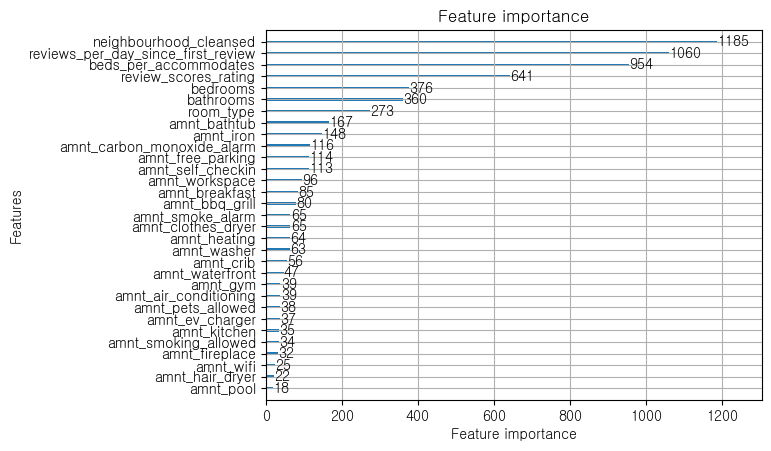

In [ ]:
# LightGBM
from lightgbm import LGBMRegressor
import lightgbm
lgbm_reg = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.08,
    max_depth=3
)

lgbm_reg.fit(X_train, y_train_log)

y_train_pred = lgbm_reg.predict(X_train)
y_test_pred = lgbm_reg.predict(X_test)
evaluate_regression(y_train_log, y_train_pred)
evaluate_regression(y_test_log, y_test_pred)
# print(lgbm_reg.score(X_train, y_train_log), lgbm_reg.score(X_test, y_test_log))

lightgbm.plot_importance(lgbm_reg)
plt.show()
# ammenities 4개, 피쳐 엔지니어링x
# learning_rate = 0.1, max_depth = 3일 때 (0.6907080289551131, 0.6522076895278469)

# 어매니티 2개, 피쳐 엔지니어링: beds per accommodate
# # learning_rate = 0.08, max_depth = 3일 때 0.6115804623784209 0.5719807289414345

# 어매니티 5개, 피쳐 엔지니어링x
# learning_rate = 0.07, max_depth = 3일 때 0.681398491692818 0.6532798175911119

# 어매니티 모두,? 피쳐 엔지니어링o
# learning_rate = 0.08, max_depth = 3일 때 0.6422197557060457 0.597910352389117

# lgbm_reg.feature_importances_

